In [102]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [103]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [104]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [105]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [106]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [107]:
import scipy.stats as stats

In [108]:
import seaborn as sns

In [109]:
from datetime import datetime

In [110]:
import re

In [111]:
from tqdm.notebook import tqdm

config = pd.Series({
    'devide_by':5
})


In [112]:

# study of skewness of the data population
def skewness(df:pd.DataFrame, column:str):
    """
    Mesures of asymetry: 
    Negative deviation indicates that the destribution skews left. The skewness of a normal distrubtion is zero. And any symetric data must have skewness equal to zero.
    The alternative to this is by lookig into the relationship between the mean and the median.
    """
    assert df[column] is not None
    assert column != ''
    
    result = 0
    series = df[column]
    data_mean = series.mean()
    data_std = series.std()
    data_count = len(series)
    
    for i in series:
        result += ((i - data_mean) * (i - data_mean) * (i - data_mean))
    result /= (data_count * data_std * data_std * data_std)
    
    return result

# Pearson median skewness coefficient
def pearson(df:pd.DataFrame, column:str):
    """
    is an alternative to skewness coefficient
    """
    assert df[column] is not None
    assert column != ''
    
    result = 0
    series = df[column]
    data_mean = series.mean()
    data_median = series.median()
    data_std = series.std()
    data_count = len(series)
    
    result = 3*(data_mean - data_median)*data_std
    
    return result

In [113]:

def get_features_nans(df:pd.DataFrame):
    result = (df.isna().sum()/df.shape[0])*100
    return result[result > 0].to_dict()

def get_features_zero(df:pd.DataFrame):
    result = (df.isin([0]).sum()/df.shape[0])*100
    return result[result > 0].to_dict()

def get_nans_counts(df:pd.DataFrame, column:str, mean_of_column:str, mean_of_value):
    return df[df[mean_of_column] == mean_of_value][column].isna().sum()

def get_columns(df: pd.DataFrame, cat_only:bool=False, num_only:bool=False) -> dict:
    if cat_only:
        cat_col = df.select_dtypes(include=['object']).columns
        return {col:len(set(df[col])) for col in cat_col}
    if num_only:
        num_col = df.select_dtypes(exclude=['object']).columns
        return {col:len(set(df[col])) for col in num_col}
    return {col:len(set(df[col])) for col in df.columns}

In [114]:
def cross_val_evaluation(model,X_train, y_train, model_name):
    scores = cross_val_score(model, X_train, y_train,cv=5) # scoring="neg_root_mean_squared_error"
    print("\n ",model_name)
    display_scores(scores)
    
def calcualte_scores(y, y_hat, show=True):
    ## Evaluate the model and plot it
    mdl_mse = mean_squared_error(y, y_hat)
    mdl_rmse = np.sqrt(mdl_mse)
    mdl_mae = mean_absolute_error(y, y_hat)
    mdl_r2score = r2_score(y, y_hat)
    
    # Best possible score is 1.0, lower values are worse.
    if show:
        print("----- EVALUATION ON VAL SET ------")
        print('MSE:', mdl_mse)
        print('RMSE', mdl_rmse)
        print('MAE:', mdl_mae)
        print('R^2: ', mdl_r2score) 
        print()
        plt.scatter(y, y_hat)
        plt.xlabel('y')
        plt.ylabel('y^')
        plt.show()
    return mdl_mse,mdl_rmse,mdl_mae,mdl_r2score

In [115]:
def show_column_counts(df:pd.DataFrame, column:str):
    assert column != ''
    assert df[column] is not None
    
    
    fig, axs = plt.subplots(3, 2, figsize=(20,10))
    axs[0][0].hist(df[column], label=f'{column} hist',bins=40)
    axs[0][0].set_xlabel('values')
    axs[0][0].set_ylabel('counts')
    axs[0][0].set_title('')

    axs[0][1].scatter(df[column].index, df[column].values, label=f'{column} scatter')
    axs[0][1].set_xlabel('index')
    axs[0][1].set_ylabel('values')
    axs[0][1].set_title('')
    
    axs[1][0].scatter(df[column].value_counts().index, df[column].value_counts().values,label=f'{column} counts')
    axs[1][0].set_xlabel('values')
    axs[1][0].set_ylabel('counts')
    axs[1][0].set_title('')
    
    axs[1][1].hist(df[column].value_counts(),label=f'{column} counts', bins=df[column].value_counts().shape[0])
    axs[1][1].set_xlabel('counts')
    axs[1][1].set_ylabel('values')
    axs[1][1].set_title('')
    
    
    axs[2][0].hist(df[column], density=True, histtype='step', cumulative=True,  linewidth=3.5, bins=30, color=sns.desaturate("indianred", .75))
    axs[2][0].set_xlabel('values')
    axs[2][0].set_ylabel('counts')
    axs[2][0].set_title('')
    
    axs[2][1].boxplot(df[column])
    axs[2][1].set_xlabel('counts')
    axs[2][1].set_ylabel('values')
    axs[2][1].set_title('')

    plt.tight_layout()
    plt.show()

In [116]:
# We need to convert the timestamp column to datetime and merge the two datasets considering year, month, day and hour. (minutes and seconds will be merged and replaced with the mean)
from typing import List
def convert_timestamp(df:pd.DataFrame, columns:List[str], sort:bool=False, add:bool=False, unit:str='s', pattern:str=None) -> pd.DataFrame:    
    for column in columns: 
        if pattern:
            df[f'{column}_date'] = pd.to_datetime(df[column], format=pattern)
        else:
            df[f'{column}_date'] = pd.to_datetime(df[column], unit=unit)
        if add:
            df = add_time_columns(df, f'{column}_date')
            df.drop(f'{column}_date', axis=1, inplace=True)
            
    if sort:
        df = df.sort_values(columns, ascending=True).reset_index(drop=True)
        
    return df

def add_time_columns(df:pd.DataFrame, column:str):
    assert column != ''
    assert df[column] is not None
    
    df[f'year_{column}'] = df[column].dt.year
    df[f'month_{column}'] = df[column].dt.month
    df[f'week_{column}'] = df[column].dt.isocalendar().week
    df[f'dayofweek_{column}'] = df[column].dt.dayofweek
    df[f'dayofmonth_{column}'] = df[column].dt.day
    df[f'dayofyear_{column}'] = df[column].dt.dayofyear
    df[f'hour_{column}'] = df[column].dt.hour
    df[f'minutes_{column}'] = df[column].dt.minute
    
    return df
    
# This function works only for data of one station
def remove_duplicates(df:pd.DataFrame, column:str) -> pd.DataFrame:
    assert column != ''
    assert df[column] is not None

    repeated_data = df[column].value_counts()[df[column].value_counts() > 1]

    for value in repeated_data.index:
        index = df[column] == value
        aux = df[index]  # taking only the ones with ttl bigger then 10
        
        candidates = aux.loc[aux['ttl'] > 10, :] if aux.loc[aux['ttl'] > 10, :].shape[0] > 1 else aux
        aux = candidates.mean().round().astype(np.int)
            
        assert df.shape[1] == aux.shape[0]
        
        df.drop(df[index].index, inplace=True)
        df = df.append(aux, ignore_index=True)
    
    # reorder the list
    df = df.sort_values(column, ascending=True).reset_index(drop=True)
    
    return df

def remove_duplicates_all(df:pd.DataFrame, column:str) -> pd.DataFrame:
    assert column != ''
    assert df[column] is not None
    
    result = {}
    
    for station_id in tqdm(df.station_id.unique().tolist()):
        df_s = df[df.station_id == station_id]
        df_s = remove_duplicates(df_s.copy(), column)
        result[station_id] = df_s.copy()
    
    # concat the result values
    df_ = pd.concat(list(result.values()), axis=0)
    
    return df_

def timestamp_multipleof(
    devide_by:int, 
    column:str,
    df:pd.DataFrame, 
    new_column:str, 
    year_column:str,
    month_column:str,
    day_column:str,
    hour_column:str,
    minutes_column:str
) -> pd.DataFrame:    
    
    # convert time to multiples of 3
    df.loc[:,[column]] = (df[column]/devide_by).apply(np.floor)*devide_by

    # create mew column of last reported and last updated 
    df[new_column] = df.apply(
        lambda x: 
        datetime(
            year=int(x[year_column]), 
            month=int(x[month_column]), 
            day=int(x[day_column]), 
            hour=int(x[hour_column]), 
            minute=int(x[minutes_column]), 
        ),
        axis=1
    )
    
    # recommended method to convert datetime to integer timestamp 
    dates = df[new_column]
    # calculate unix datetime
    df[new_column] = (dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return df


ranks:  [4.0, 1.0, 2.0, 3.0]
Pearson rank coefficient: 0.27
Spearman rank coefficient: 0.80


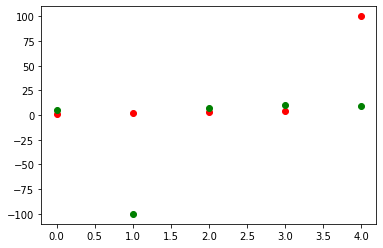

In [117]:
def Cov(X, Y):
    def _get_dvis(V):
        return [v - np.mean(V) for v in V]
    dxis = _get_dvis(X)
    dyis = _get_dvis(Y)
    return np.sum([x * y for x, y in zip(dxis, dyis)])/len(X)

def PearsonCorr(X, Y):
    assert len(X) == len(Y)
    return Cov(X, Y) / np.prod([np.std(V) for V in [X, Y]])

def list2rank(l):
    #l is a list of numbers
    # returns a list of 1-based index; mean when multiple instances
    return [np.mean([i+1 for i, sorted_el in enumerate(sorted(l)) if sorted_el == el]) for el in l]

l = [7, 1, 2, 5]
print("ranks: ", list2rank(l))

def spearmanRank(X, Y):
    # X and Y are same-length lists
    return PearsonCorr(list2rank(X), list2rank(Y))

X = [1, 2, 3, 4, 100]
Y = [5, -100, 7, 10, 9]
plt.plot(X,'ro')
plt.plot(Y,'go')

print("Pearson rank coefficient: %.2f" % PearsonCorr(X, Y))
print("Spearman rank coefficient: %.2f" % spearmanRank(X, Y))

In [118]:
%%html
<style>
    p {
        float:left
    }  
    table {
        display: inline-block
    }
</style>

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)<p><td>
        <tr>
    <table>
<div>

# Read data 2019 marc

|  | info |
| -- | -- |
|  | The data for 2019 marc are from 2019-03-28 17:54:30 until 2019-03-31 21:53:56 |

# New data 2019 Marc 

In [119]:
dades_2019_Marc_info = pd.read_csv('dades/2019/BicingNou_ESTACIONS/2019_03_Marc_BicingNou_ESTACIONS.csv')

In [120]:
dades_2019_Marc_info['is_charging_station'] = dades_2019_Marc_info.is_charging_station.astype(np.int)

In [121]:
# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info['status'].replace(to_replace=['CLOSED', 'IN_SERVICE'], value=[0, 1], inplace=True)

In [122]:
dades_2019_Marc_info = convert_timestamp(dades_2019_Marc_info.copy(), ['last_reported', 'last_updated'], sort=True, add=True)

## dades_2019_Marc_info

In [123]:
dades_2019_Marc_info.shape

(355467, 29)

In [124]:
get_features_nans(dades_2019_Marc_info)

{}

In [125]:
get_features_zero(dades_2019_Marc_info)

{'num_bikes_available': 20.440997335898974,
 'num_bikes_available_types.mechanical': 20.440997335898974,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 13.242298159885447,
 'hour_last_reported_date': 4.083079441973517,
 'minutes_last_reported_date': 1.1359704276346327,
 'hour_last_updated_date': 4.040881432031665,
 'minutes_last_updated_date': 0.11224670644532403}

In [126]:
get_columns(dades_2019_Marc_info)

{'station_id': 399,
 'num_bikes_available': 55,
 'num_bikes_available_types.mechanical': 55,
 'num_bikes_available_types.ebike': 1,
 'num_docks_available': 55,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'last_reported': 180636,
 'is_charging_station': 1,
 'status': 1,
 'last_updated': 891,
 'ttl': 30,
 'year_last_reported_date': 1,
 'month_last_reported_date': 1,
 'week_last_reported_date': 1,
 'dayofweek_last_reported_date': 4,
 'dayofmonth_last_reported_date': 4,
 'dayofyear_last_reported_date': 4,
 'hour_last_reported_date': 24,
 'minutes_last_reported_date': 60,
 'year_last_updated_date': 1,
 'month_last_updated_date': 1,
 'week_last_updated_date': 1,
 'dayofweek_last_updated_date': 4,
 'dayofmonth_last_updated_date': 4,
 'dayofyear_last_updated_date': 4,
 'hour_last_updated_date': 24,
 'minutes_last_updated_date': 16}

In [127]:
dades_2019_Marc_info.head(5)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,year_last_reported_date,month_last_reported_date,week_last_reported_date,dayofweek_last_reported_date,dayofmonth_last_reported_date,dayofyear_last_reported_date,hour_last_reported_date,minutes_last_reported_date,year_last_updated_date,month_last_updated_date,week_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date,minutes_last_updated_date
0,236,2,2,0,22,1,1,1,1553795555,1,1,1553795923,23,2019,3,13,3,28,87,17,52,2019,3,13,3,28,87,17,58
1,51,20,20,0,0,1,1,1,1553795609,1,1,1553795923,23,2019,3,13,3,28,87,17,53,2019,3,13,3,28,87,17,58
2,65,21,21,0,0,1,1,1,1553795664,1,1,1553795923,23,2019,3,13,3,28,87,17,54,2019,3,13,3,28,87,17,58
3,155,0,0,0,32,1,1,1,1553795664,1,1,1553795923,23,2019,3,13,3,28,87,17,54,2019,3,13,3,28,87,17,58
4,343,26,26,0,1,1,1,1,1553795664,1,1,1553795923,23,2019,3,13,3,28,87,17,54,2019,3,13,3,28,87,17,58


## ttl

In [128]:
print(stats.describe(dades_2019_Marc_info.ttl))
dades_2019_Marc_info.ttl.describe()

DescribeResult(nobs=355467, minmax=(1, 30), mean=18.08985925557084, variance=93.46467373998793, skewness=-0.13862617593168738, kurtosis=-1.4097612851961863)


count    355467.000000
mean         18.089859
std           9.667713
min           1.000000
25%           9.000000
50%          18.000000
75%          29.000000
max          30.000000
Name: ttl, dtype: float64

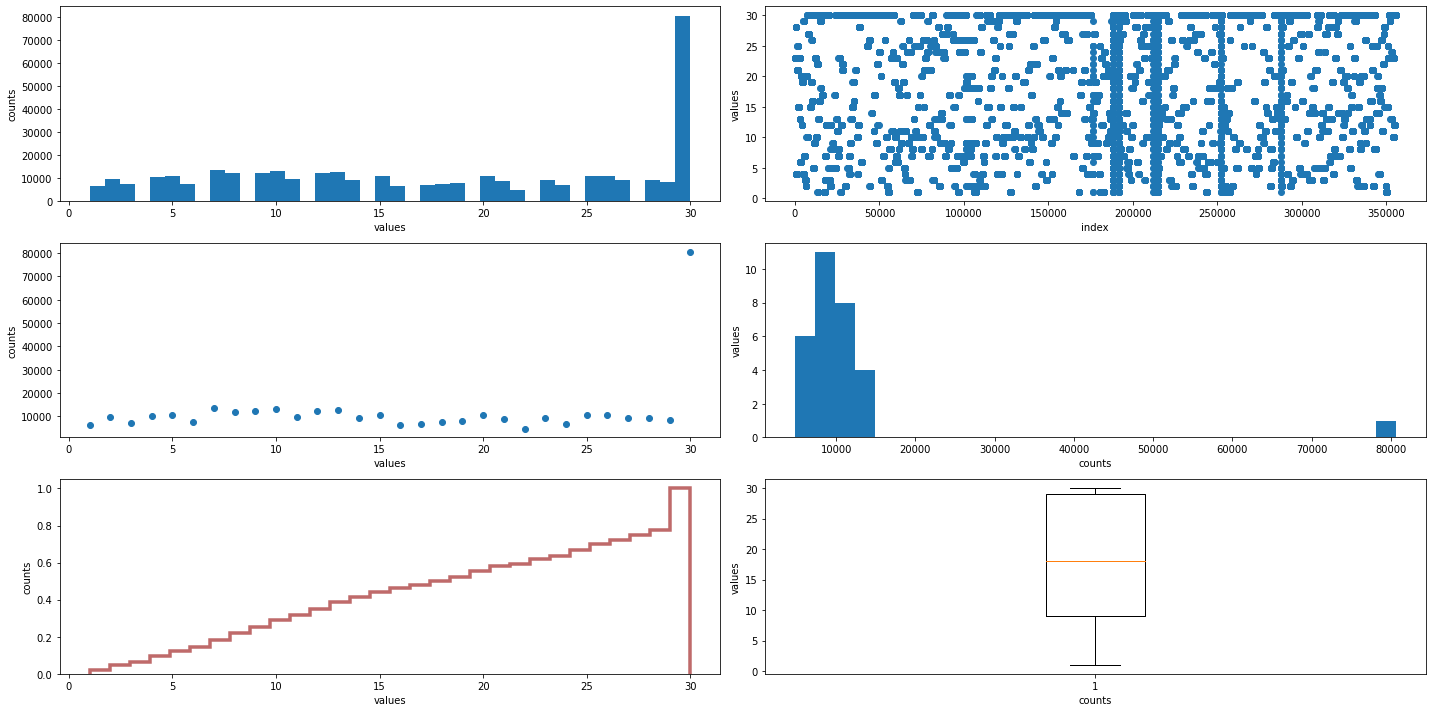

In [129]:
show_column_counts(dades_2019_Marc_info, 'ttl')

### Study on TTL for station 1
Taking one station ID and looking for the best TTL for multiple answers from the same time


In [130]:
dades_marc_2019_info_s1 = dades_2019_Marc_info[dades_2019_Marc_info.station_id == 1]

### last_updated 

|  | info |
| -- | -- |
|  | last updates is the timestamp for the file |
|  | a station id will never have repeated last_updated timestamp in the dataset |

In [131]:
(dades_marc_2019_info_s1.last_updated.value_counts() > 1).any()  # give insight if there any last_updated timestamps is repeated 

False

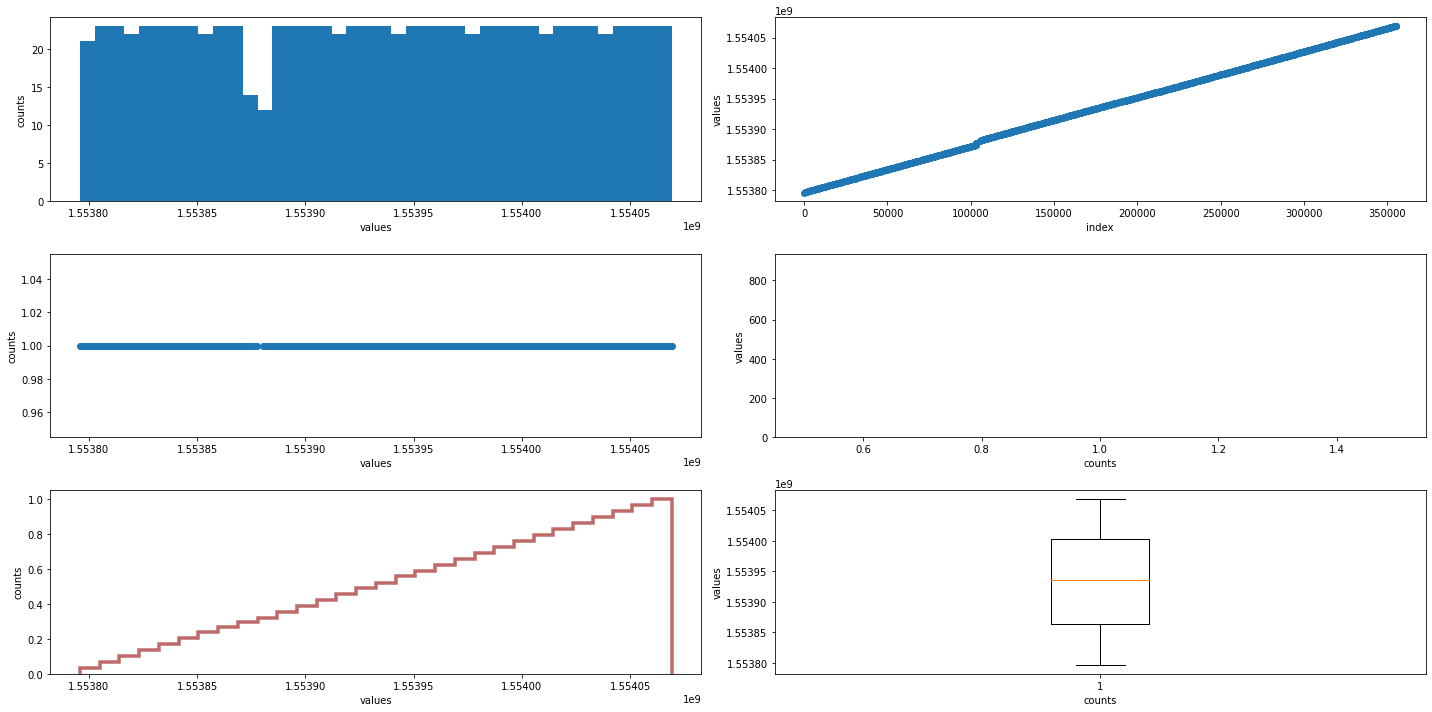

In [132]:
show_column_counts(dades_marc_2019_info_s1, 'last_updated')

### last_reported

|  | info |
| -- | -- |
|  |  |

In [133]:
(dades_marc_2019_info_s1.last_reported.value_counts() > 1).any()

True

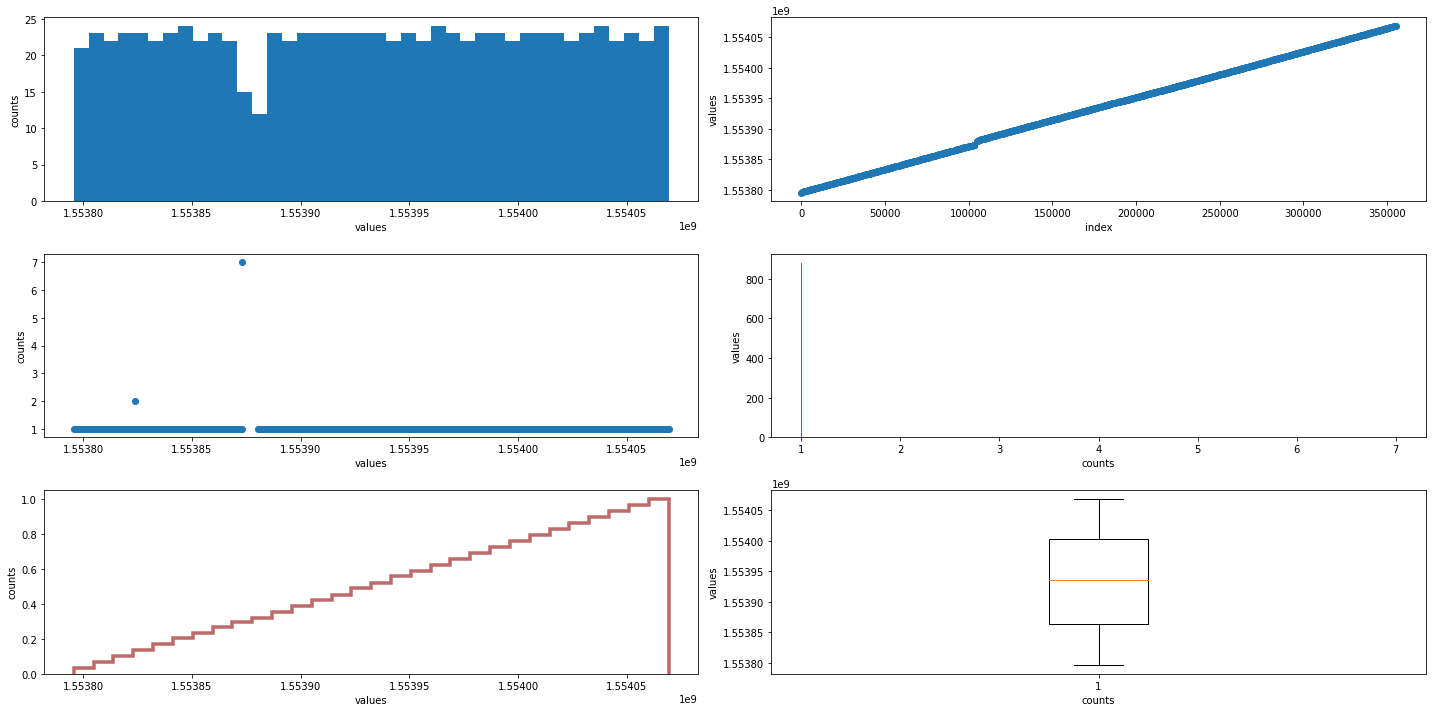

In [134]:
show_column_counts(dades_marc_2019_info_s1, 'last_reported')

In [135]:
# will remove the duplicate for last reported
dades_marc_2019_info_s1 = remove_duplicates(dades_marc_2019_info_s1.copy(), 'last_reported')

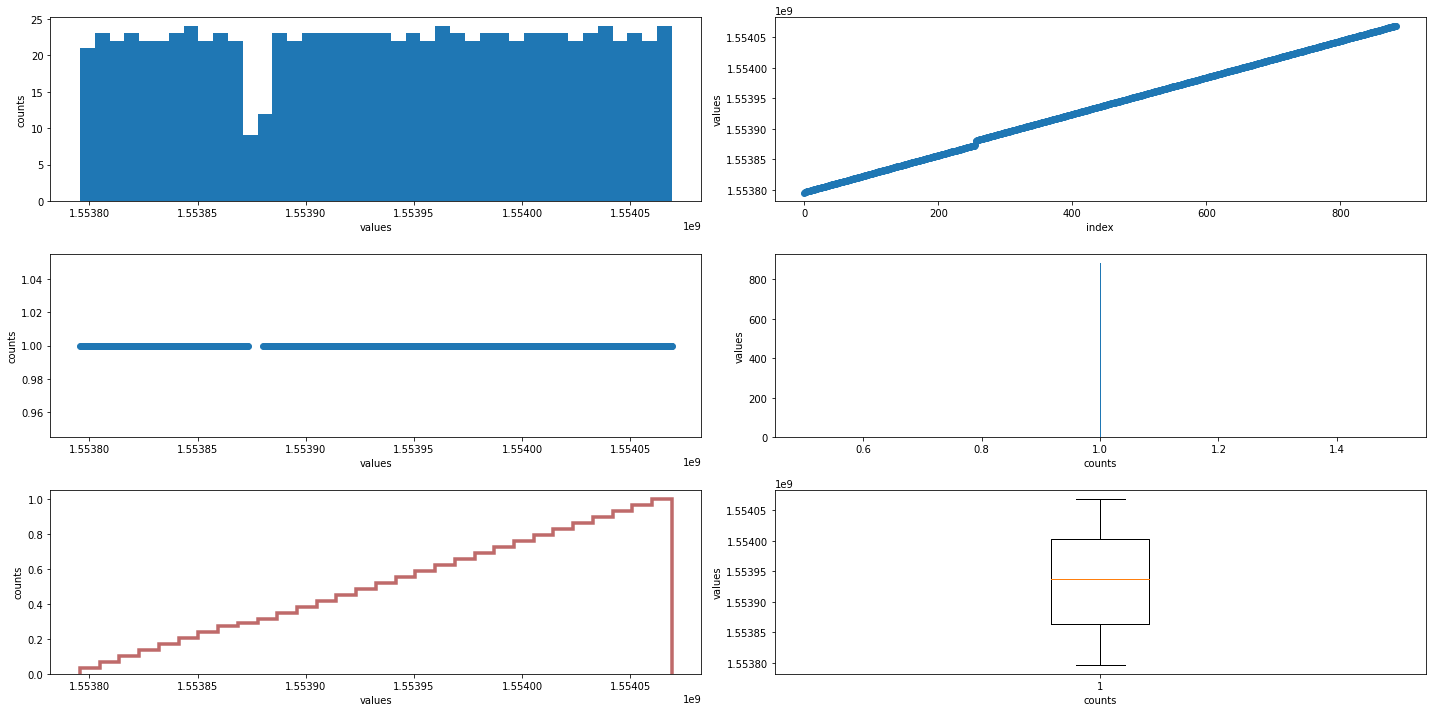

In [136]:
show_column_counts(dades_marc_2019_info_s1, 'last_reported')

## station_id

In [137]:
print(stats.describe(dades_2019_Marc_info.station_id))
dades_2019_Marc_info.station_id.describe()

DescribeResult(nobs=355467, minmax=(1, 496), mean=215.1967496279542, variance=15450.670156145794, skewness=0.06210974302108455, kurtosis=-1.0841759773963147)


count    355467.000000
mean        215.196750
std         124.300725
min           1.000000
25%         109.000000
50%         214.000000
75%         320.000000
max         496.000000
Name: station_id, dtype: float64

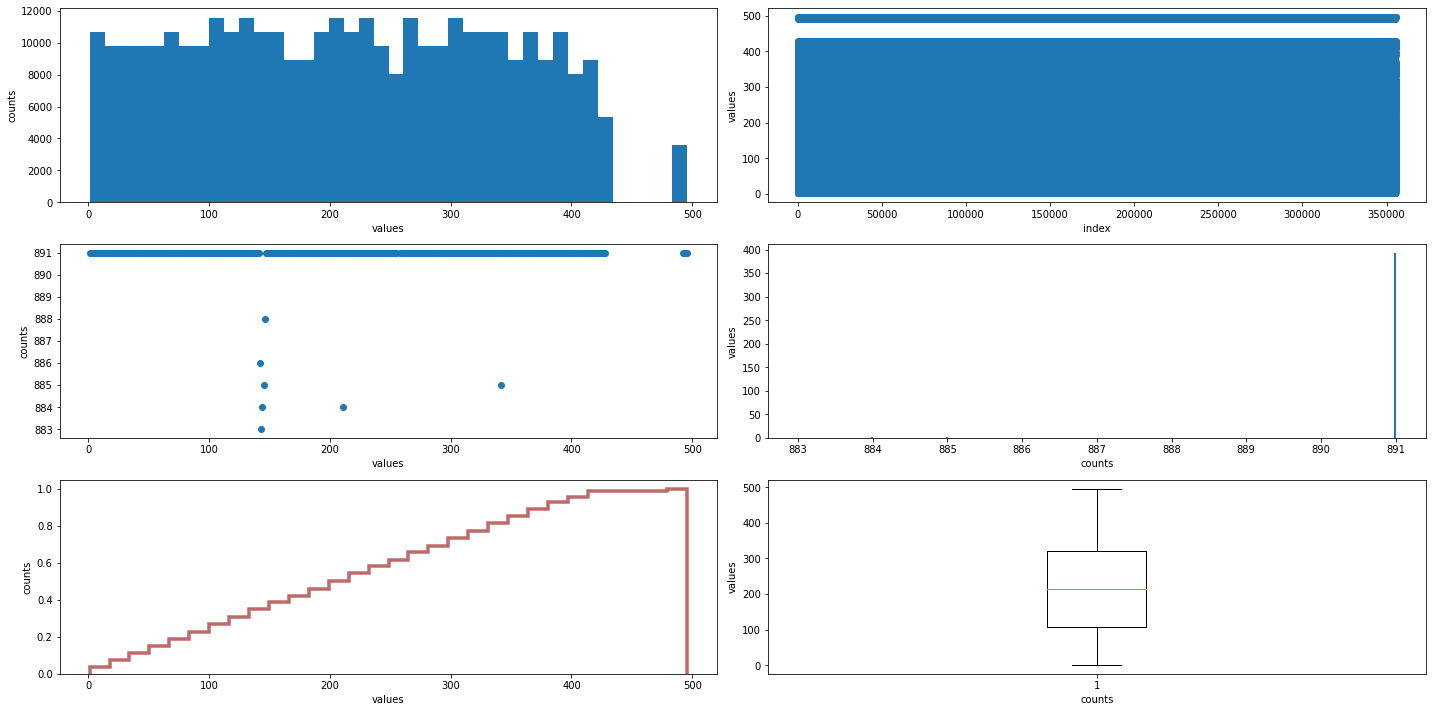

In [138]:
# station_id 
# Most values are repeated equally in the dataset
show_column_counts(dades_2019_Marc_info, 'station_id')

## num_bikes_available

In [139]:
# num_bikes_available
# by looking at the differance between the 75% and max number 
# existance of outliers is possible. 54 is too big for a station size
# TODO, check max size of a station? Replace outliers with the maximum size
print(stats.describe(dades_2019_Marc_info.num_bikes_available))
dades_2019_Marc_info.num_bikes_available.describe()

DescribeResult(nobs=355467, minmax=(0, 54), mean=12.274807506744649, variance=118.32815636011216, skewness=0.4800406321795607, kurtosis=-0.612264885501896)


count    355467.000000
mean         12.274808
std          10.877875
min           0.000000
25%           1.000000
50%          11.000000
75%          21.000000
max          54.000000
Name: num_bikes_available, dtype: float64

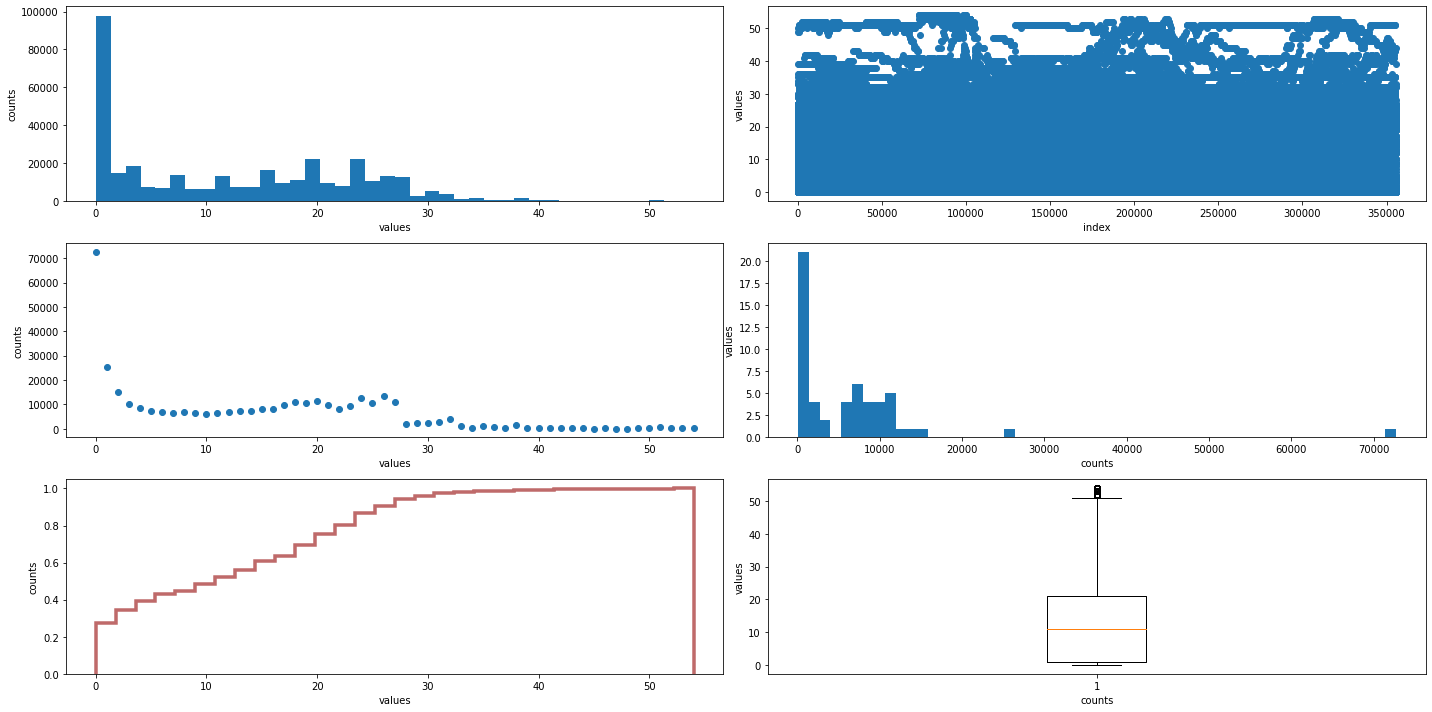

In [140]:
show_column_counts(dades_2019_Marc_info, 'num_bikes_available')

## num_docks_available

In [141]:
print(stats.describe(dades_2019_Marc_info.num_docks_available))
dades_2019_Marc_info.num_docks_available.describe()

DescribeResult(nobs=355467, minmax=(0, 54), mean=13.479979857483254, variance=112.04875930934541, skewness=0.18349701625906567, kurtosis=-1.257827725458595)


count    355467.000000
mean         13.479980
std          10.585309
min           0.000000
25%           2.000000
50%          13.000000
75%          23.000000
max          54.000000
Name: num_docks_available, dtype: float64

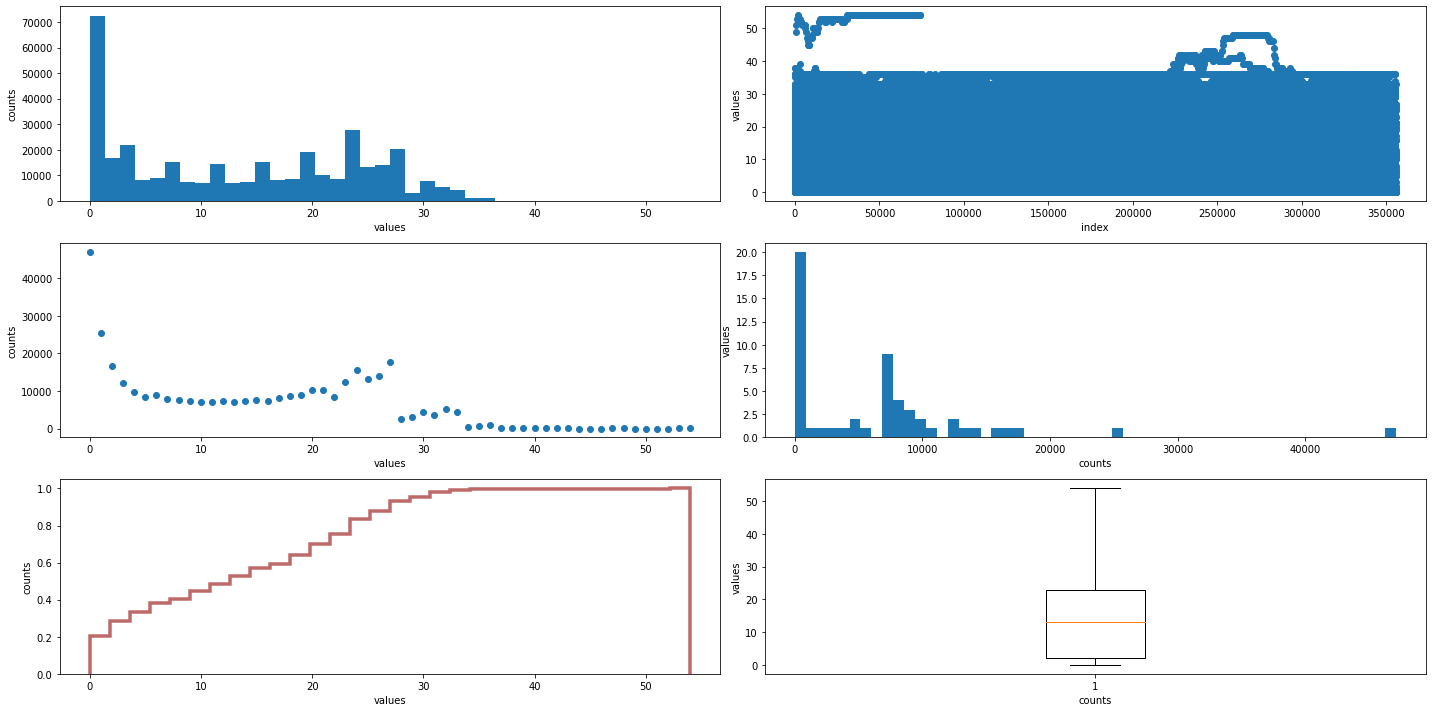

In [142]:
show_column_counts(dades_2019_Marc_info, 'num_docks_available')

# Preprocessing the data 

In [143]:
dades_2019_Marc_info = pd.read_csv('dades/2019/BicingNou_ESTACIONS/2019_03_Marc_BicingNou_ESTACIONS.csv')

print(dades_2019_Marc_info.shape)

# change column to one hot enconding
dades_2019_Marc_info['is_charging_station'] = dades_2019_Marc_info.is_charging_station.astype(np.int)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info['status'].replace(to_replace=['CLOSED', 'IN_SERVICE'], value=[0, 1], inplace=True)

# will remove the duplicate for last reported for all stations in the dataset
dades_2019_Marc_info = remove_duplicates_all(dades_2019_Marc_info.copy(), 'last_reported')

# convert timestamps of last_updated
dades_2019_Marc_info = convert_timestamp(dades_2019_Marc_info.copy(), ['last_updated'], sort=True, add=True)

# convert timestamps to multimple of 3
dades_2019_Marc_info = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_info.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_info.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_info.drop('last_reported', axis=1, inplace=True)

print(dades_2019_Marc_info.shape)

(355467, 13)


  0%|          | 0/399 [00:00<?, ?it/s]

(349863, 12)


In [144]:
dades_2019_Marc_info

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,is_charging_station,status,last_updated,ttl
0,1,16,16,0,14,1,1,1,1,1,1553795700,23
1,41,13,13,0,7,1,1,1,1,1,1553795700,23
2,327,0,0,0,24,1,1,1,1,1,1553795700,23
3,326,0,0,0,32,1,1,1,1,1,1553795700,23
4,42,8,8,0,14,1,1,1,1,1,1553795700,23
...,...,...,...,...,...,...,...,...,...,...,...,...
349858,67,0,0,0,0,1,1,1,1,1,1554069000,30
349859,189,15,15,0,12,1,1,1,1,1,1554069000,30
349860,216,0,0,0,26,1,1,1,1,1,1554069000,30
349861,11,13,13,0,7,1,1,1,1,1,1554069000,30


# dades_2019_Marc_us

In [145]:
dades_2019_Marc_us = pd.read_csv('dades/2019/BicingNou_INFORMACIO/2019_03_Marc_BicingNou_INFORMACIO.csv')

print(dades_2019_Marc_us.shape)

dades_2019_Marc_us = convert_timestamp(dades_2019_Marc_us.copy(), ['last_updated'], sort=True, add=True)

(352674, 11)


## Fixing error in data

In [146]:
dades_2019_Marc_us.altitude.value_counts()

0                                       351790
01 - C/ GRAN VIA CORTS CATALANES 760       884
Name: altitude, dtype: int64

In [147]:
# dades_2019_Marc_us[~(dades_2019_Marc_us.altitude == "0")] # 884 row  does not have 0 in the altitud column
cond = (~(dades_2019_Marc_us.altitude == "0") & (dades_2019_Marc_us.capacity == 1))
print(dades_2019_Marc_us[cond].shape) 
# 884 row does not have 0 in the altitud column
# capacity is filled with values 1 to fix this we need to shift the data 

# Fix data 
dades_2019_Marc_us.loc[cond, ['capacity']] = dades_2019_Marc_us[cond].post_code
dades_2019_Marc_us.loc[cond, ['post_code']] = dades_2019_Marc_us[cond].address
dades_2019_Marc_us.loc[cond, ['address']] = dades_2019_Marc_us[cond].altitude
dades_2019_Marc_us.loc[cond, ['altitude']] = '0'

(884, 19)


In [148]:
cond = (~(dades_2019_Marc_us.altitude == "0") & (dades_2019_Marc_us.capacity == 1))
dades_2019_Marc_us[cond].head(5)

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,last_updated,ttl,year_last_updated_date,month_last_updated_date,week_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date,minutes_last_updated_date


In [149]:
dades_2019_Marc_us.altitude.value_counts()

0    352674
Name: altitude, dtype: int64

## Study

In [150]:
get_features_nans(dades_2019_Marc_us)

{}

In [151]:
get_features_zero(dades_2019_Marc_us)

{'capacity': 0.3578375496917834,
 'hour_last_updated_date': 4.072883172561629,
 'minutes_last_updated_date': 0.11313564368226749}

In [152]:
get_columns(dades_2019_Marc_us)

{'station_id': 399,
 'name': 399,
 'physical_configuration': 1,
 'lat': 399,
 'lon': 399,
 'altitude': 1,
 'address': 399,
 'post_code': 3,
 'capacity': 33,
 'last_updated': 884,
 'ttl': 30,
 'year_last_updated_date': 1,
 'month_last_updated_date': 1,
 'week_last_updated_date': 1,
 'dayofweek_last_updated_date': 4,
 'dayofmonth_last_updated_date': 4,
 'dayofyear_last_updated_date': 4,
 'hour_last_updated_date': 24,
 'minutes_last_updated_date': 15}

## ttl

In [153]:
print(stats.describe(dades_2019_Marc_us.ttl))
dades_2019_Marc_us.ttl.describe()

DescribeResult(nobs=352674, minmax=(1, 30), mean=18.459373245546878, variance=95.53655766067209, skewness=-0.2902947969210823, kurtosis=-1.3529447699081723)


count    352674.000000
mean         18.459373
std           9.774280
min           1.000000
25%           9.000000
50%          20.000000
75%          28.000000
max          30.000000
Name: ttl, dtype: float64

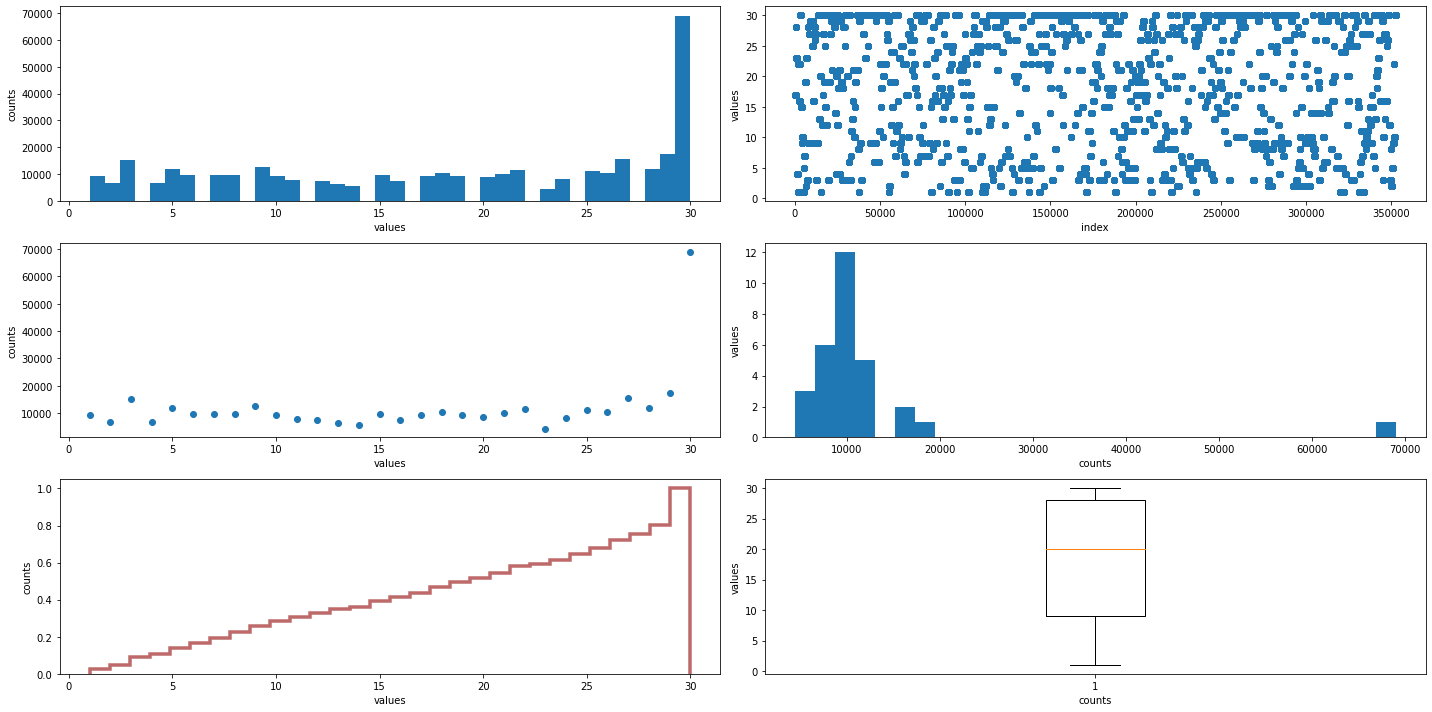

In [154]:
show_column_counts(dades_2019_Marc_us, 'ttl')

### Study on TTL for station 1
Taking one station ID and looking for the best TTL for multiple answers from the same time


In [155]:
dades_2019_Marc_us_s1 = dades_2019_Marc_us[dades_2019_Marc_us.station_id == 1]

### last_updated 

|  | info |
| -- | -- |
|  | last updates is the timestamp for the file |
|  | a station id will never have repeated last_updated timestamp in the dataset |

In [156]:
(dades_2019_Marc_us_s1.last_updated.value_counts() > 1).any()  # give insight if there any last_updated timestamps is repeated 

False

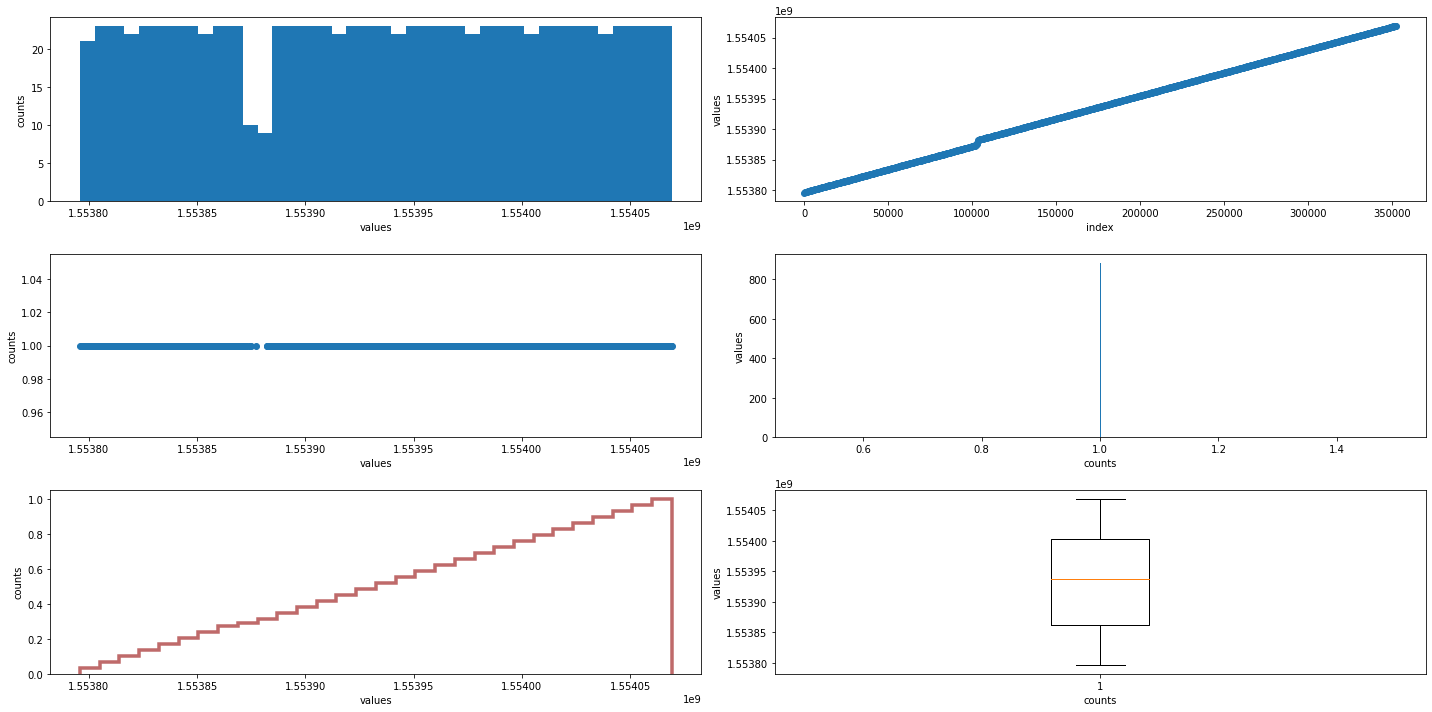

In [157]:
show_column_counts(dades_2019_Marc_us_s1, 'last_updated')

In [158]:
dades_2019_Marc_us.drop(['last_updated','ttl'], axis=1, inplace=True)

## station_id

In [159]:
print(stats.describe(dades_2019_Marc_us.station_id))
dades_2019_Marc_us.station_id.describe()

DescribeResult(nobs=352674, minmax=(1, 496), mean=215.19677946205277, variance=15450.679509636726, skewness=0.06210900743938997, kurtosis=-1.084176694009516)


count    352674.000000
mean        215.196779
std         124.300762
min           1.000000
25%         109.000000
50%         214.000000
75%         320.000000
max         496.000000
Name: station_id, dtype: float64

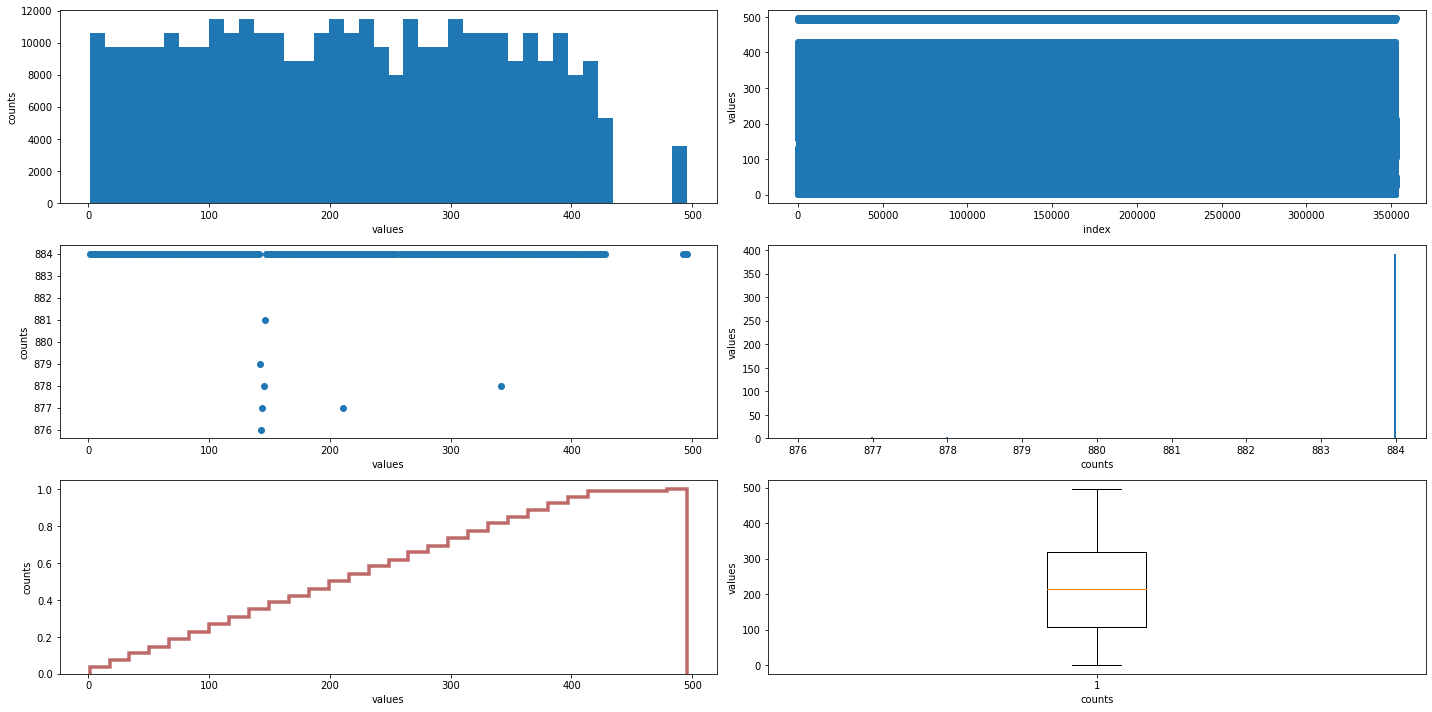

In [160]:
show_column_counts(dades_2019_Marc_us, 'station_id')

## lat

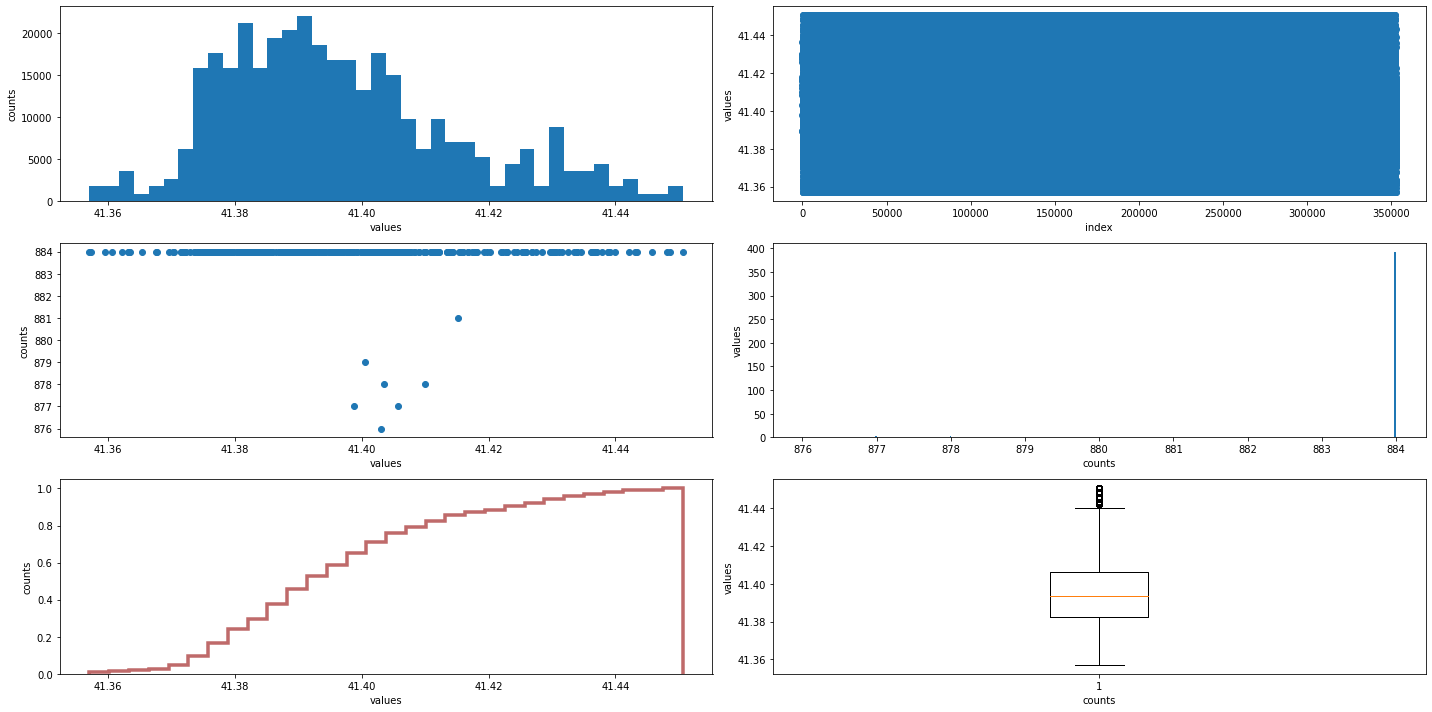

In [161]:
show_column_counts(dades_2019_Marc_us, 'lat')

## lon

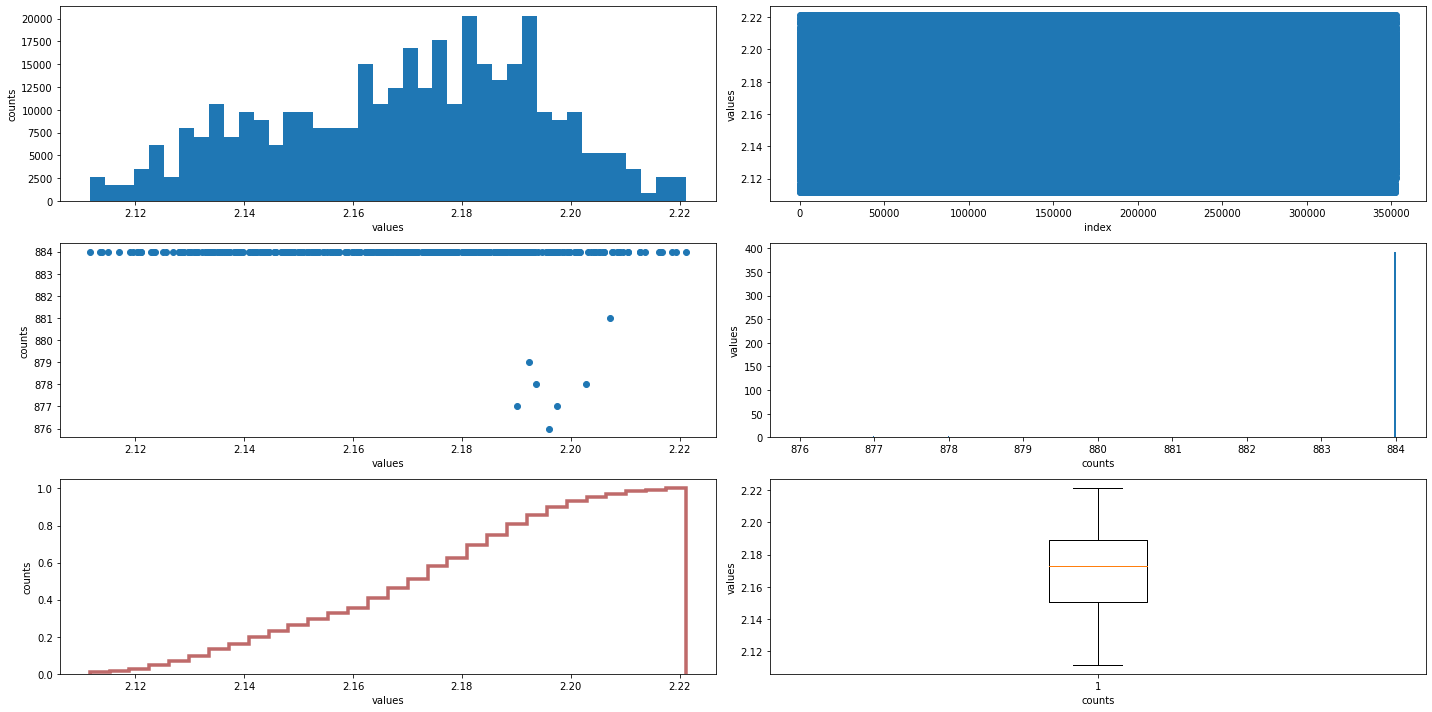

In [162]:
show_column_counts(dades_2019_Marc_us, 'lon')

## capacity

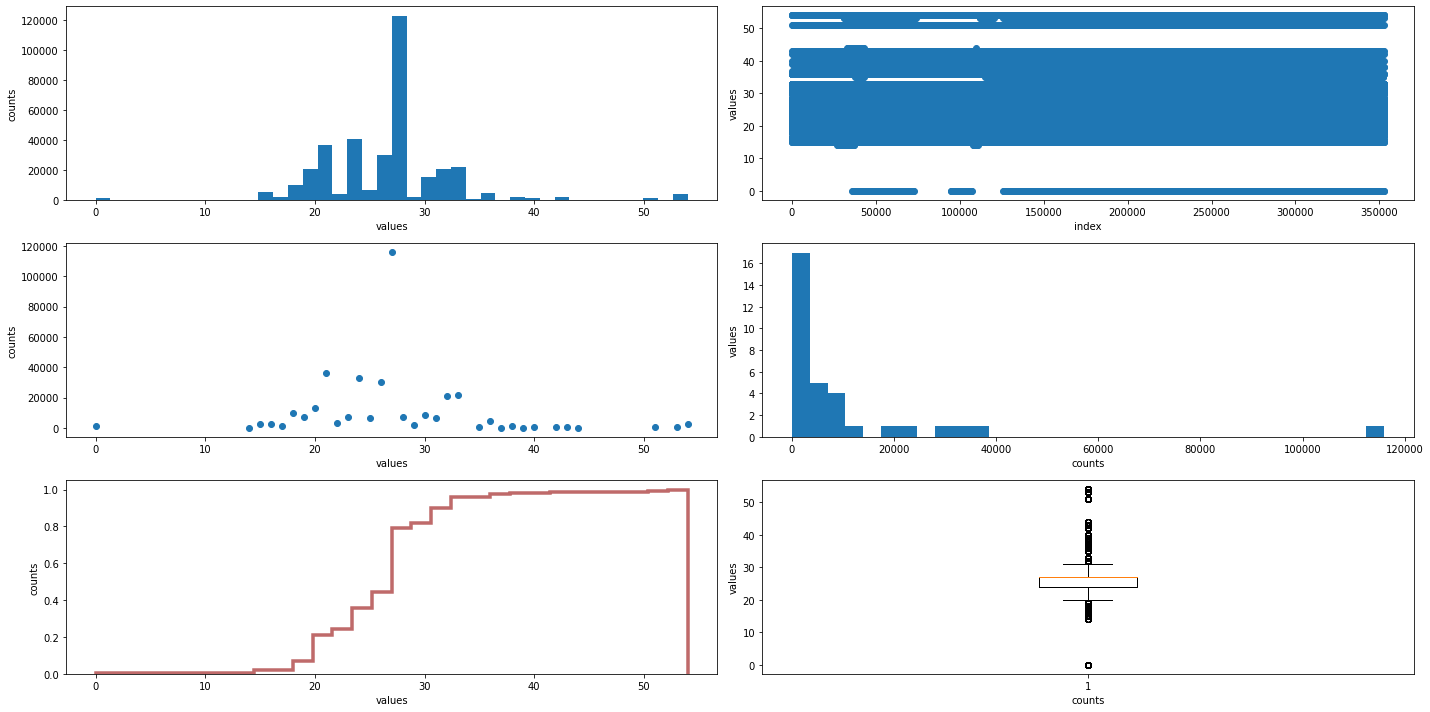

In [163]:
show_column_counts(dades_2019_Marc_us, 'capacity')

## post_code

In [164]:
# post code is wrong need fixing using long & lat. 
# can be fixed using post code data from old dataset after the merge
dades_2019_Marc_us['post_code'] = '08908'
dades_2019_Marc_us.post_code.value_counts()

08908    352674
Name: post_code, dtype: int64

# Preprocessing the data 

In [165]:
dades_2019_Marc_us = pd.read_csv('dades/2019/BicingNou_INFORMACIO/2019_03_Marc_BicingNou_INFORMACIO.csv')

print(dades_2019_Marc_us.shape)

# dades_2019_Marc_us[~(dades_2019_Marc_us.altitude == "0")] # 884 row  does not have 0 in the altitud column
cond = (~(dades_2019_Marc_us.altitude == "0") & (dades_2019_Marc_us.capacity == 1))
print(dades_2019_Marc_us[cond].shape) 
# 884 row does not have 0 in the altitud column
# capacity is filled with values 1 to fix this we need to shift the data 

# Fix data 
dades_2019_Marc_us.loc[cond, ['capacity']] = dades_2019_Marc_us[cond].post_code
dades_2019_Marc_us.loc[cond, ['post_code']] = dades_2019_Marc_us[cond].address
dades_2019_Marc_us.loc[cond, ['address']] = dades_2019_Marc_us[cond].altitude
dades_2019_Marc_us.loc[cond, ['altitude']] = '0'

# post code is wrong need fixing using long & lat. 
# can be fixed using post code data from old dataset after the merge
dades_2019_Marc_us['post_code'] = '08908'

dades_2019_Marc_us = convert_timestamp(dades_2019_Marc_us.copy(), ['last_updated'], sort=True, add=True)

# convert timestamps to multimple of 3
dades_2019_Marc_us = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_us.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_us.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

# create mew column of last reported and last updated 
dades_2019_Marc_us['streetName'] = df.apply(
    lambda x: " ".join(re.findall("[a-zA-Z]+", x['name'])),
    axis=1
)


# create mew column of last reported and last updated 
dades_2019_Marc_us['streetNumber'] = df.apply(
    lambda x: re.findall("\d+$", x['name'])[0],
    axis=1
)

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_us.drop(['name', 'address'], axis=1, inplace=True)

print(dades_2019_Marc_us.shape)


(352674, 11)
(884, 11)


NameError: name 'df' is not defined

# merge data us with data info

In [ ]:
dades_2019_Marc_info.head(1)

In [ ]:
dades_2019_Marc_info.shape

In [ ]:
dades_2019_Marc_us.head(1)

In [ ]:
dades_2019_Marc_us.shape

In [67]:
merged_data = dades_2019_Marc_info.merge(
    dades_2019_Marc_us.copy(), 
    left_on=[
        'station_id',
        'last_updated'
    ], 
    right_on=[
        'station_id',
        'last_updated'
    ],
    how='left',
    suffixes=("_stat", "_us")
).copy()

merged_data.shape

(351050, 22)

In [68]:
merged_data[merged_data.last_reported.isna()].shape[0], merged_data.shape[0],(merged_data[merged_data.last_reported.isna()].shape[0]/merged_data.shape[0])*100

(0, 351050, 0.0)

In [69]:
merged_data[[
    'num_bikes_available',
    'num_bikes_available_types.mechanical', 
    'num_bikes_available_types.ebike', 
    'num_docks_available', 
    'is_installed', 
    'is_renting', 
    'is_returning', 
    'last_reported', 
    'is_charging_station', 
    'status',
    'last_updated'
]] = merged_data[[
    'num_bikes_available',
    'num_bikes_available_types.mechanical', 
    'num_bikes_available_types.ebike', 
    'num_docks_available', 
    'is_installed', 
    'is_renting', 
    'is_returning', 
    'last_reported', 
    'is_charging_station', 
    'status', 
    'last_updated'
]].astype(np.int)

In [70]:
merged_data['physical_configuration'].replace(to_replace=['BIKESTATION', 'ELECTRICBIKESTATION'], value=[0, 1], inplace=True)

In [71]:
merged_data.columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'last_reported',
       'is_charging_station', 'status', 'last_updated', 'ttl_stat', 'name',
       'physical_configuration', 'lat', 'lon', 'altitude', 'address',
       'post_code', 'capacity', 'ttl_us'],
      dtype='object')

In [72]:
merged_data.head(5)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl_stat,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,ttl_us
0,1,16,16,0,14,1,1,1,1553795670,1,1,1553795700,23,01 - C/ GRAN VIA CORTS CATALANES 760,1.0,41.397952,2.180042,0,01 - C/ GRAN VIA CORTS CATALANES 760,08908,30.0,17.0
1,41,13,13,0,7,1,1,1,1553795807,1,1,1553795700,23,41 - PL. POETA BOSCÀ/ATLÀNTIDA,1.0,41.379326,2.189906,0,41 - PL. POETA BOSCÀ/ATLÀNTIDA,08908,21.0,17.0
2,327,0,0,0,24,1,1,1,1553795900,1,1,1553795700,23,"327 - C/ REUS, 23",1.0,41.405000,2.134530,0,"327 - C/ REUS, 23",08908,24.0,17.0
3,326,0,0,0,32,1,1,1,1553795890,1,1,1553795700,23,"326 - C/BALMES, 409",1.0,41.407384,2.138300,0,"326 - C/BALMES, 409",08908,32.0,17.0
4,42,8,8,0,14,1,1,1,1553795718,1,1,1553795700,23,42 - C/ CIUTAT DE GRANADA 168 / AV. DIAGONAL,1.0,41.404511,2.189881,0,42 - C/ CIUTAT DE GRANADA 168 / AV. DIAGONAL,08908,23.0,17.0


In [73]:
get_features_nans(merged_data)

{'name': 0.645492095143142,
 'physical_configuration': 0.645492095143142,
 'lat': 0.645492095143142,
 'lon': 0.645492095143142,
 'altitude': 0.645492095143142,
 'address': 0.645492095143142,
 'post_code': 0.645492095143142,
 'capacity': 0.645492095143142,
 'ttl_us': 0.645492095143142}

In [74]:
get_features_zero(merged_data)

{'num_bikes_available': 20.462612163509473,
 'num_bikes_available_types.mechanical': 20.462612163509473,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 13.164221620851729,
 'capacity': 0.3592080900156673}

In [75]:
get_columns(merged_data)

{'station_id': 399,
 'num_bikes_available': 55,
 'num_bikes_available_types.mechanical': 55,
 'num_bikes_available_types.ebike': 1,
 'num_docks_available': 55,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'last_reported': 180636,
 'is_charging_station': 1,
 'status': 1,
 'last_updated': 897,
 'ttl_stat': 30,
 'name': 400,
 'physical_configuration': 2267,
 'lat': 2665,
 'lon': 2665,
 'altitude': 2,
 'address': 400,
 'post_code': 2,
 'capacity': 2299,
 'ttl_us': 2296}

In [76]:
merged_data.shape

(351050, 22)

## last_updated

In [77]:
print(stats.describe(merged_data.last_updated))
merged_data.last_updated.describe()

DescribeResult(nobs=351050, minmax=(1553795700, 1554069000), mean=1553933859.5362484, variance=6270756704.393124, skewness=-0.04384157545927313, kurtosis=-1.198775141031875)


count    3.510500e+05
mean     1.553934e+09
std      7.918811e+04
min      1.553796e+09
25%      1.553862e+09
50%      1.553936e+09
75%      1.554002e+09
max      1.554069e+09
Name: last_updated, dtype: float64

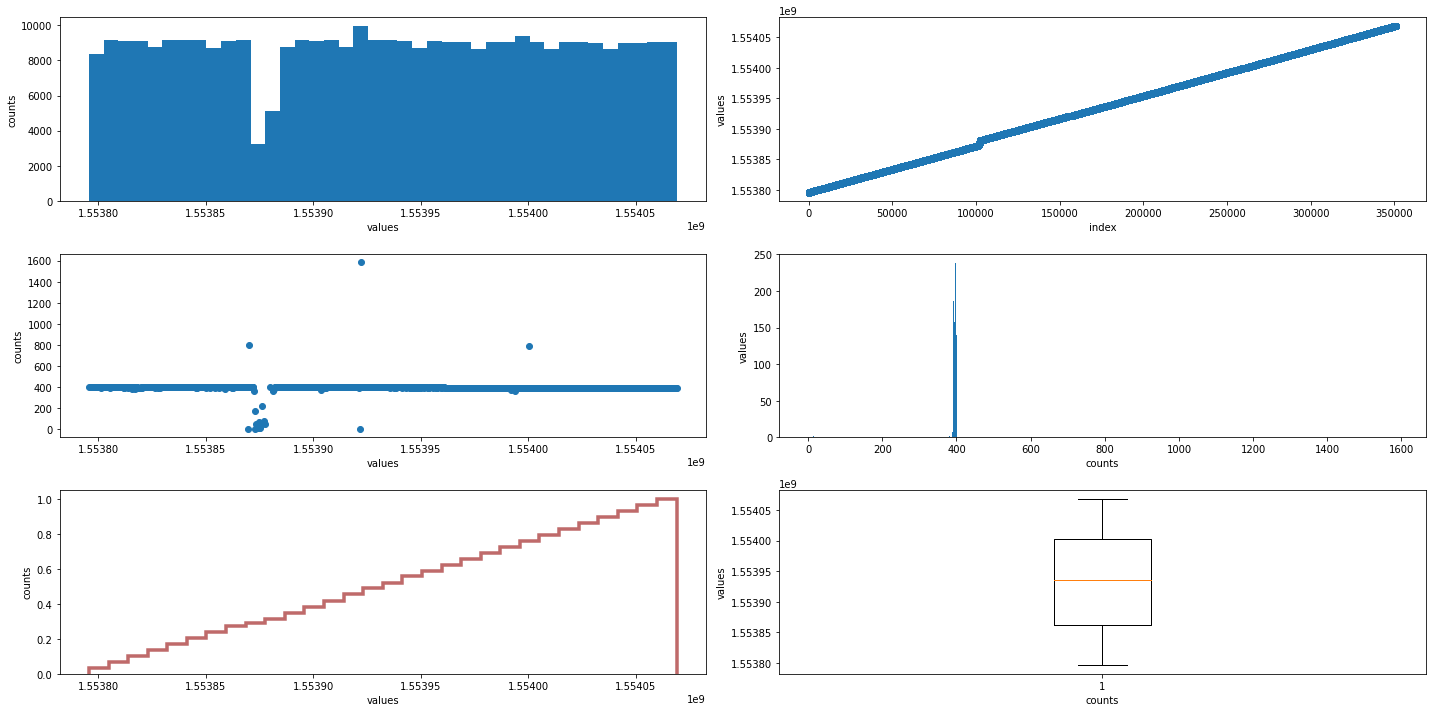

In [78]:
show_column_counts(merged_data, 'last_updated')

# Old data 2019 Gener, Febrer, Marc 

In [79]:
dades_2019_Marc_info_old = pd.read_csv('dades/2019/BICING_ESTACIONS/2019_03_Marc_BICING_ESTACIONS.csv')

print(dades_2019_Marc_info_old.shape)

dades_2019_Marc_info_old.rename(
    columns={
        'id': 'station_id',
        'latitude':'lat',
        'longitude':'lon',
        'type':'physical_configuration',
        'updateTime':'last_updated',
        'bikes':'num_bikes_available',
        'slots':'num_docks_available',
    }, 
    inplace=True
)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info_old['status'].replace(to_replace=['CLS', 'OPN'], value=[0, 1], inplace=True)

dades_2019_Marc_info_old['physical_configuration'].replace(to_replace=['BIKE', 'BIKE-ELECTRIC'], value=[0, 1], inplace=True)

dades_2019_Marc_info_old['is_installed'] = 1
dades_2019_Marc_info_old['is_renting'] = 1
dades_2019_Marc_info_old['is_returning'] = 1
dades_2019_Marc_info_old['is_charging_station'] = 1
dades_2019_Marc_info_old['num_bikes_available_types.mechanical'] = dades_2019_Marc_info_old['num_bikes_available']
dades_2019_Marc_info_old['num_bikes_available_types.ebike'] = 0
dades_2019_Marc_info_old['name'] = ''
dades_2019_Marc_info_old['post_code'] = ''
dades_2019_Marc_info_old['capacity'] = 0

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_info_old.drop('nearbyStations', axis=1, inplace=True)

dades_2019_Marc_info_old = convert_timestamp(dades_2019_Marc_info_old.copy(), ['last_updated'], sort=True, add=True, pattern='%d/%m/%y %H:%M:%S')

# convert timestamps to multimple of 3
dades_2019_Marc_info_old = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_info_old.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_info_old.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

print(dades_2019_Marc_info_old.shape)


/home/user/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3954821, 12)
(3954821, 22)


In [83]:
# check if conversion was done correctly
df = dades_2019_Marc_info_old.groupby(
    [
        'station_id',
        'last_updated'
    ]
).count().reset_index()

df.max()

station_id                                     496
last_updated                            1554076200
physical_configuration                           1
lat                                              1
lon                                              1
streetName                                       1
streetNumber                                     1
altitude                                         1
num_docks_available                              1
num_bikes_available                              1
nearbyStations                                   1
status                                           1
is_installed                                     1
is_renting                                       1
is_returning                                     1
is_charging_station                              1
num_bikes_available_types.mechanical             1
num_bikes_available_types.ebike                  1
name                                             1
address                        

## station_id

In [80]:
print(stats.describe(dades_2019_Marc_info_old.station_id))
dades_2019_Marc_info_old.station_id.describe()

DescribeResult(nobs=3954821, minmax=(1, 496), mean=237.37146308265278, variance=19244.333279069368, skewness=0.08867316123444308, kurtosis=-1.0910925338677862)


count    3.954821e+06
mean     2.373715e+02
std      1.387239e+02
min      1.000000e+00
25%      1.180000e+02
50%      2.350000e+02
75%      3.500000e+02
max      4.960000e+02
Name: station_id, dtype: float64

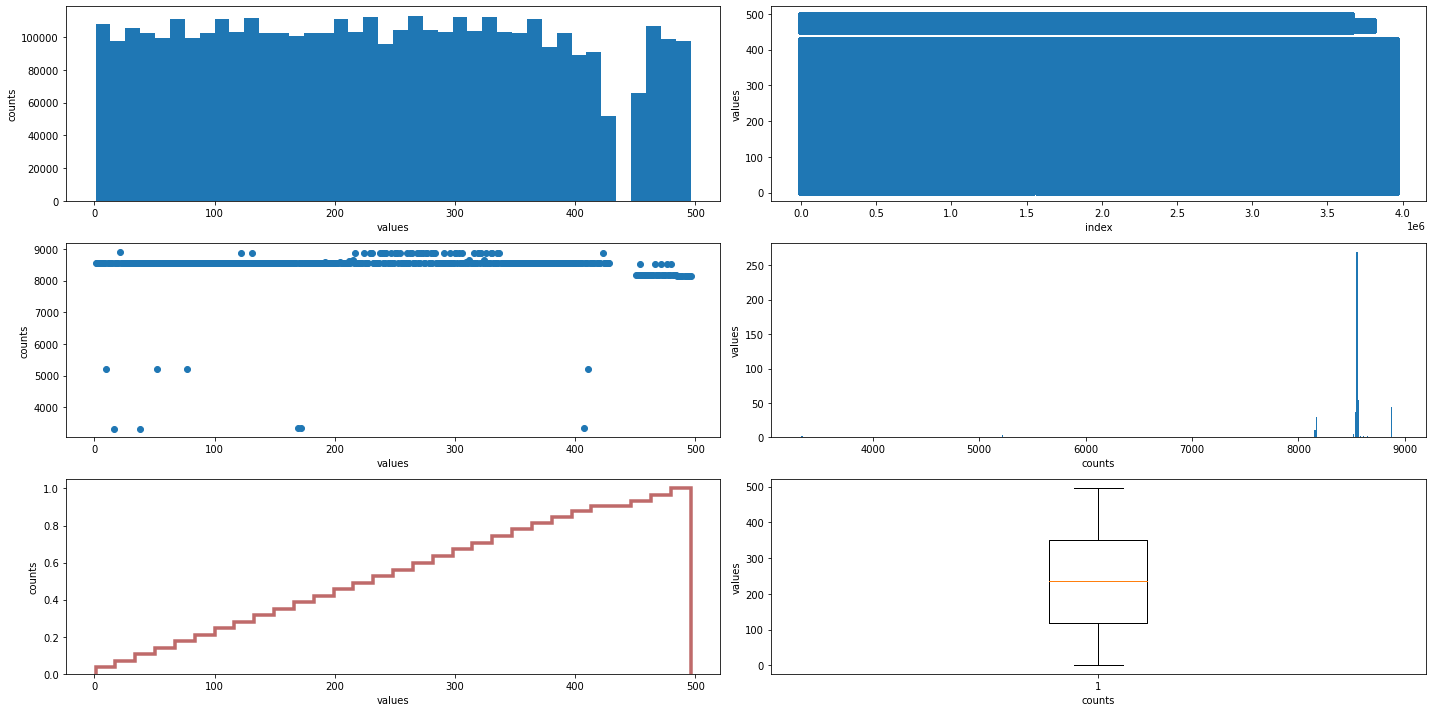

In [81]:
show_column_counts(dades_2019_Marc_info_old, 'station_id')

## last_updated

In [85]:
print(stats.describe(dades_2019_Marc_info_old.last_updated))
dades_2019_Marc_info_old.last_updated.describe()

DescribeResult(nobs=3954821, minmax=(1551398100, 1554076200), mean=1552735069.0644405, variance=607513024831.6741, skewness=-0.028066515368717317, kurtosis=-1.2392757207070098)


count    3.954821e+06
mean     1.552735e+09
std      7.794312e+05
min      1.551398e+09
25%      1.552039e+09
50%      1.552769e+09
75%      1.553411e+09
max      1.554076e+09
Name: last_updated, dtype: float64

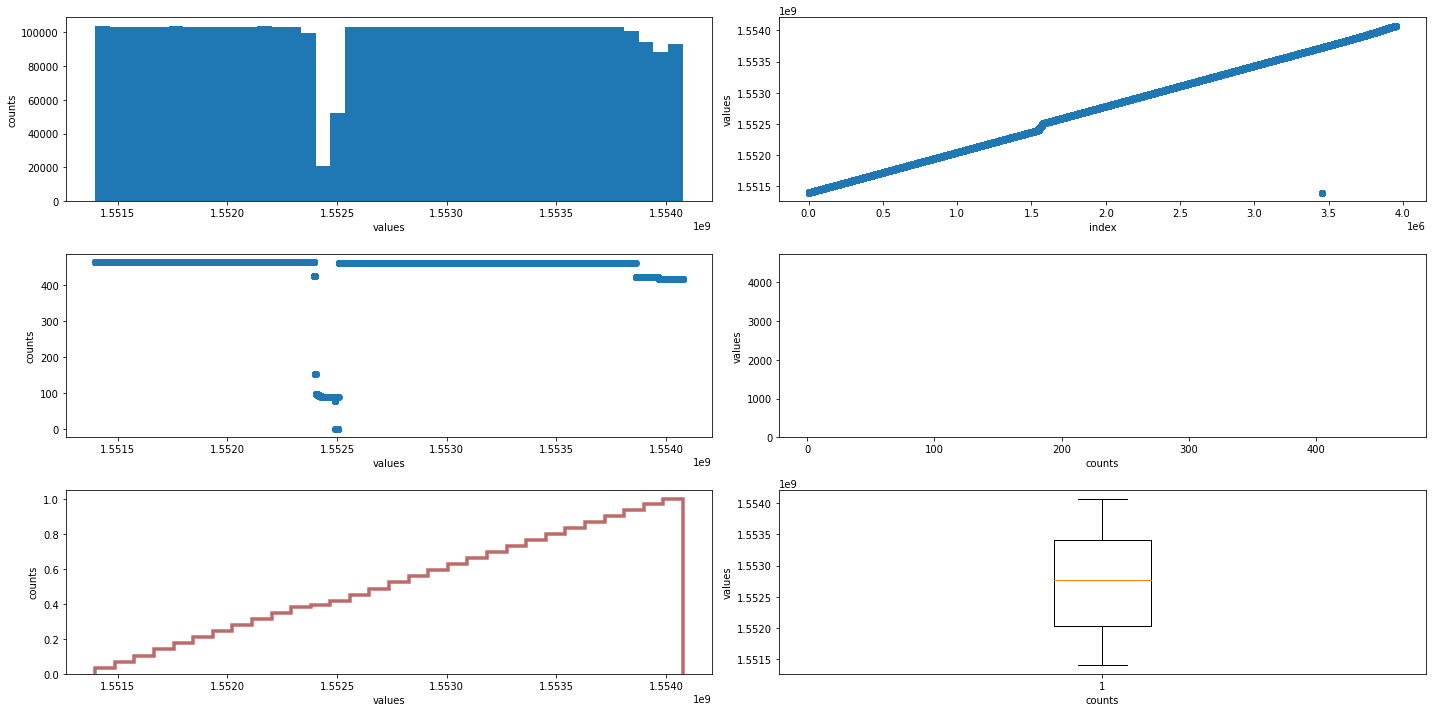

In [86]:
show_column_counts(dades_2019_Marc_info_old, 'last_updated')

In [89]:
dades_2019_Marc_info_old

,station_id,physical_configuration,lat,lon,streetName,streetNumber,altitude,num_docks_available,num_bikes_available,nearbyStations,status,last_updated,is_installed,is_renting,is_returning,is_charging_station,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,name,address,post_code,capacity
0,234,0,41.371515,2.162166,Passeig de l'Exposició,30,44,14,9,"85, 236",1,1551398400,1,1,1,1,9,0,,,,0
1,149,0,41.395905,2.192958,Pujades,57B,11,26,0,149,0,1551398400,1,1,1,1,0,0,,,,0
2,150,0,41.406549,2.203112,Espronceda,124,10,26,1,150,0,1551398400,1,1,1,1,1,0,,,,0
3,151,0,41.400650,2.197190,Pallars,462,6,24,0,151,0,1551398400,1,1,1,1,0,0,,,,0
4,152,0,41.399250,2.197421,Pujades,121,11,27,0,152,0,1551398400,1,1,1,1,0,0,,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954816,136,0,41.414226,2.201734,Gran Vía,1062,9,4,22,136,0,1554076200,1,1,1,1,22,0,,,,0
3954817,135,0,41.411908,2.197936,Gran Vía,981,13,21,0,135,0,1554076200,1,1,1,1,0,0,,,,0
3954818,134,0,41.411433,2.198735,Bac de Roda,157,10,20,0,134,0,1554076200,1,1,1,1,0,0,,,,0
3954819,105,0,41.389197,2.173555,PL. Urquinaona,9,32,18,0,105,0,1554076200,1,1,1,1,0,0,,,,0


# Merge data Marc old with new

In [87]:
dades_2019_Marc_info_old.columns

Index(['station_id', 'physical_configuration', 'lat', 'lon', 'streetName',
       'streetNumber', 'altitude', 'num_docks_available',
       'num_bikes_available', 'nearbyStations', 'status', 'last_updated',
       'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'name', 'address', 'post_code',
       'capacity'],
      dtype='object')

In [88]:
merged_data.columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'last_reported',
       'is_charging_station', 'status', 'last_updated', 'ttl_stat', 'name',
       'physical_configuration', 'lat', 'lon', 'altitude', 'address',
       'post_code', 'capacity', 'ttl_us'],
      dtype='object')

In [90]:
%%time

dades_2019_Marc_tot = pd.concat([merged_data,dades_2019_Marc_info_old])

CPU times: user 277 ms, sys: 210 ms, total: 488 ms
Wall time: 486 ms


In [91]:
dades_2019_Marc_tot.reset_index(drop = True)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl_stat,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,ttl_us,streetName,streetNumber,nearbyStations
0,1,16,16,0,14,1,1,1,1.553796e+09,1,1,1553795700,23.0,01 - C/ GRAN VIA CORTS CATALANES 760,1.0,41.397952,2.180042,0,01 - C/ GRAN VIA CORTS CATALANES 760,08908,30.0,17.0,NaN,NaN,NaN
1,41,13,13,0,7,1,1,1,1.553796e+09,1,1,1553795700,23.0,41 - PL. POETA BOSCÀ/ATLÀNTIDA,1.0,41.379326,2.189906,0,41 - PL. POETA BOSCÀ/ATLÀNTIDA,08908,21.0,17.0,NaN,NaN,NaN
2,327,0,0,0,24,1,1,1,1.553796e+09,1,1,1553795700,23.0,"327 - C/ REUS, 23",1.0,41.405000,2.134530,0,"327 - C/ REUS, 23",08908,24.0,17.0,NaN,NaN,NaN
3,326,0,0,0,32,1,1,1,1.553796e+09,1,1,1553795700,23.0,"326 - C/BALMES, 409",1.0,41.407384,2.138300,0,"326 - C/BALMES, 409",08908,32.0,17.0,NaN,NaN,NaN
4,42,8,8,0,14,1,1,1,1.553796e+09,1,1,1553795700,23.0,42 - C/ CIUTAT DE GRANADA 168 / AV. DIAGONAL,1.0,41.404511,2.189881,0,42 - C/ CIUTAT DE GRANADA 168 / AV. DIAGONAL,08908,23.0,17.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305866,136,22,22,0,4,1,1,1,NaN,1,0,1554076200,NaN,,0.0,41.414226,2.201734,9,,,0.0,NaN,Gran Vía,1062,136
4305867,135,0,0,0,21,1,1,1,NaN,1,0,1554076200,NaN,,0.0,41.411908,2.197936,13,,,0.0,NaN,Gran Vía,981,135
4305868,134,0,0,0,20,1,1,1,NaN,1,0,1554076200,NaN,,0.0,41.411433,2.198735,10,,,0.0,NaN,Bac de Roda,157,134
4305869,105,0,0,0,18,1,1,1,NaN,1,0,1554076200,NaN,,0.0,41.389197,2.173555,32,,,0.0,NaN,PL. Urquinaona,9,105


In [92]:
dades_2019_Marc_tot.shape

(4305871, 25)

In [93]:
get_features_nans(dades_2019_Marc_tot)

{'last_reported': 91.8471779577233,
 'ttl_stat': 91.8471779577233,
 'name': 0.05262582181398374,
 'physical_configuration': 0.05262582181398374,
 'lat': 0.05262582181398374,
 'lon': 0.05262582181398374,
 'altitude': 0.05262582181398374,
 'address': 0.05262582181398374,
 'post_code': 0.05262582181398374,
 'capacity': 0.05262582181398374,
 'ttl_us': 91.8998037795373,
 'streetName': 8.152822042276696,
 'streetNumber': 15.175117879750694,
 'nearbyStations': 8.152822042276696}

In [94]:
get_features_zero(dades_2019_Marc_tot)

{'num_bikes_available': 72.81265509347587,
 'num_bikes_available_types.mechanical': 72.81265509347587,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 2.337970645195827,
 'status': 76.64804635345554,
 'physical_configuration': 83.2767168361523,
 'altitude': 3.135509633242612,
 'capacity': 91.87646355406375}

In [ ]:
get_columns(dades_2019_Marc_tot)

## ttl

In [ ]:
print(stats.describe(dades_2019_Marc_tot.ttl))
dades_2019_Marc_tot.ttl.describe()

In [ ]:
show_column_counts(dades_2019_Marc_tot, 'ttl')

### Study on TTL for station 1
Taking one station ID and looking for the best TTL for multiple answers from the same time


In [ ]:
dades_2019_Marc_tot_s1 = dades_2019_Marc_tot[dades_2019_Marc_tot.station_id == 1]

In [ ]:
dades_2019_Marc_tot_s1.shape

In [ ]:
get_features_nans(dades_2019_Marc_tot_s1)

In [ ]:
get_features_zero(dades_2019_Marc_tot_s1)

In [ ]:
get_columns(dades_2019_Marc_tot_s1)

In [ ]:
dades_2019_Marc_tot_s1.head(5)

### last_updated 

|  | info |
| -- | -- |
|  | last updates is the timestamp for the file |
|  | a station id will never have repeated last_updated timestamp in the dataset |

In [ ]:
(dades_2019_Marc_tot_s1.last_updated.value_counts() > 1).any()  # give insight if there any last_updated timestamps is repeated 

In [ ]:
show_column_counts(dades_2019_Marc_tot_s1, 'last_updated')

### last_reported

|  | info |
| -- | -- |
|  |  |

In [ ]:
(dades_2019_Marc_tot_s1.last_reported.value_counts() > 1).any()

In [ ]:
show_column_counts(dades_2019_Marc_tot_s1, 'last_reported')

In [ ]:
dades_2019_Marc_tot_s1 = remove_duplicates(dades_2019_Marc_tot_s1.copy(), 'last_reported')

In [ ]:
show_column_counts(dades_2019_Marc_tot_s1, 'last_reported')

## station_id

In [ ]:
print(stats.describe(dades_2019_Marc_tot.station_id))
dades_2019_Marc_tot.station_id.describe()

In [ ]:
# station_id 
# Most values are repeated equally in the dataset
show_column_counts(dades_2019_Marc_tot, 'station_id')

## num_bikes_available

In [ ]:
# num_bikes_available
# by looking at the differance between the 75% and max number 
# existance of outliers is possible. 54 is too big for a station size
# TODO, check max size of a station? Replace outliers with the maximum size
print(stats.describe(dades_2019_Marc_tot.num_bikes_available))
dades_2019_Marc_tot.num_bikes_available.describe()

In [ ]:
show_column_counts(dades_2019_Marc_tot, 'num_bikes_available')

## num_docks_available

In [ ]:
print(stats.describe(dades_2019_Marc_tot.num_docks_available))
dades_2019_Marc_tot.num_docks_available.describe()

In [ ]:
show_column_counts(dades_2019_Marc_tot, 'num_docks_available')

## Cleaning and store of new file

# Study of station id 1 year 2019 complete